UAS PDA
FAIZ IRSYAD FAHREZI
41822010054

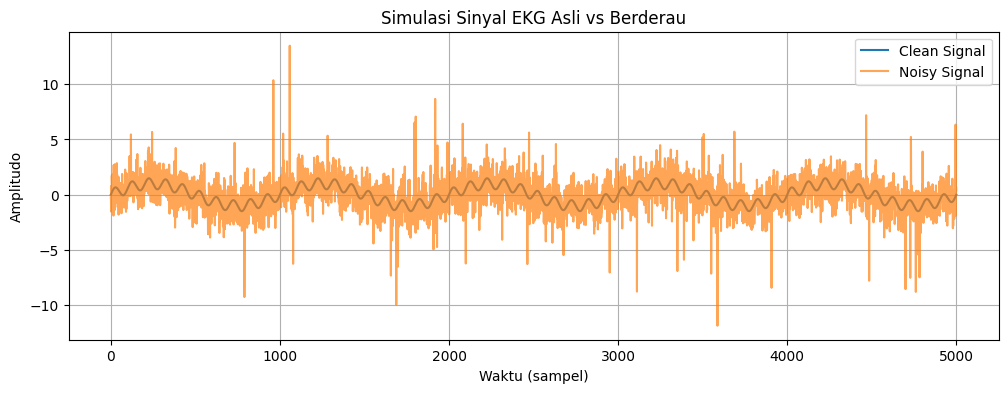

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Simulasi sinyal EKG asli (bersih)
np.random.seed(42)
n_samples = 5000
t = np.linspace(0, 1, n_samples)
ekg_clean = np.sin(2 * np.pi * 5 * t) + 0.5 * np.sin(2 * np.pi * 50 * t)

# Simulasi noise (Gaussian + spike noise)
gaussian_noise = np.random.normal(0, 0.3, n_samples)
spike_noise = np.random.normal(0, 1, n_samples)
spike_noise[np.random.rand(n_samples) > 0.98] *= 5  # sedikit spike besar
total_noise = gaussian_noise + spike_noise

# Sinyal berderau
ekg_noisy = ekg_clean + total_noise

# Simpan sebagai DataFrame
df = pd.DataFrame({'Clean': ekg_clean, 'Noisy': ekg_noisy})

# Plot hasilnya
plt.figure(figsize=(12, 4))
plt.plot(df['Clean'], label="Clean Signal")
plt.plot(df['Noisy'], alpha=0.7, label="Noisy Signal")
plt.legend()
plt.title("Simulasi Sinyal EKG Asli vs Berderau")
plt.xlabel("Waktu (sampel)")
plt.ylabel("Amplitudo")
plt.grid(True)
plt.show()


In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Fungsi untuk memecah sinyal jadi potongan (window)
def window_signal(signal, size=256):
    return np.array([signal[i:i+size] for i in range(0, len(signal)-size)])

# Siapkan data untuk input dan target
X_noisy = window_signal(df['Noisy'].values)
Y_clean = window_signal(df['Clean'].values)

# Normalisasi
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_noisy)
Y_scaled = scaler.transform(Y_clean)

# Reshape agar cocok untuk Conv1D
X = X_scaled.reshape((-1, 256, 1))
Y = Y_scaled.reshape((-1, 256, 1))

# Split data training dan testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D, Add
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Blok residual
def residual_block(x, filters):
    conv1 = Conv1D(filters, 3, padding='same', activation='relu')(x)
    conv2 = Conv1D(filters, 3, padding='same', activation='relu')(conv1)
    return Add()([x, conv2])

# Arsitektur ResUNet 1D
input_layer = Input(shape=(256, 1))

# Encoder
e1 = Conv1D(64, 3, padding='same', activation='relu')(input_layer)
p1 = MaxPooling1D(2)(e1)

e2 = Conv1D(128, 3, padding='same', activation='relu')(p1)
p2 = MaxPooling1D(2)(e2)

# Bottleneck
b = residual_block(p2, 128)

# Decoder
u2 = UpSampling1D(2)(b)
d2 = Conv1D(128, 3, padding='same', activation='relu')(u2)

u1 = UpSampling1D(2)(d2)
d1 = Conv1D(64, 3, padding='same', activation='relu')(u1)

output_layer = Conv1D(1, 1, padding='same')(d1)

# Kompilasi
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=Adam(), loss='mse')

# Training
history = model.fit(X_train, Y_train, validation_split=0.2, epochs=50, batch_size=32, verbose=1)


Epoch 1/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 14s 119ms/step - loss: 0.0280 - val_loss: 1.8475e-04
Epoch 2/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - loss: 1.5635e-04 - val_loss: 1.0714e-04
Epoch 3/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 19s 105ms/step - loss: 1.0039e-04 - val_loss: 8.3126e-05
Epoch 4/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - loss: 7.8998e-05 - val_loss: 8.2187e-05
Epoch 5/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 21s 121ms/step - loss: 7.0832e-05 - val_loss: 6.6377e-05
Epoch 6/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 19s 104ms/step - loss: 6.9801e-05 - val_loss: 9.4156e-05
Epoch 7/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step - loss: 7.0621e-05 - val_loss: 6.2896e-05
Epoch 8/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 21s 114ms/step - loss: 6.2369e-05 - val_loss: 5.9989e-05
Epoch 9/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 20s 104ms/step - loss: 6.2431e-05 - val_loss: 7.5569e-05
Epoch 10/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 6.6173e-05 - val_loss: 6.0466e-05
Epoch 11/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 21s 116ms/step

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
RMSE rata-rata: 0.006488753857018786
PRD rata-rata: 1.3904169370691204
SNR rata-rata (dB): 37.29746260836332


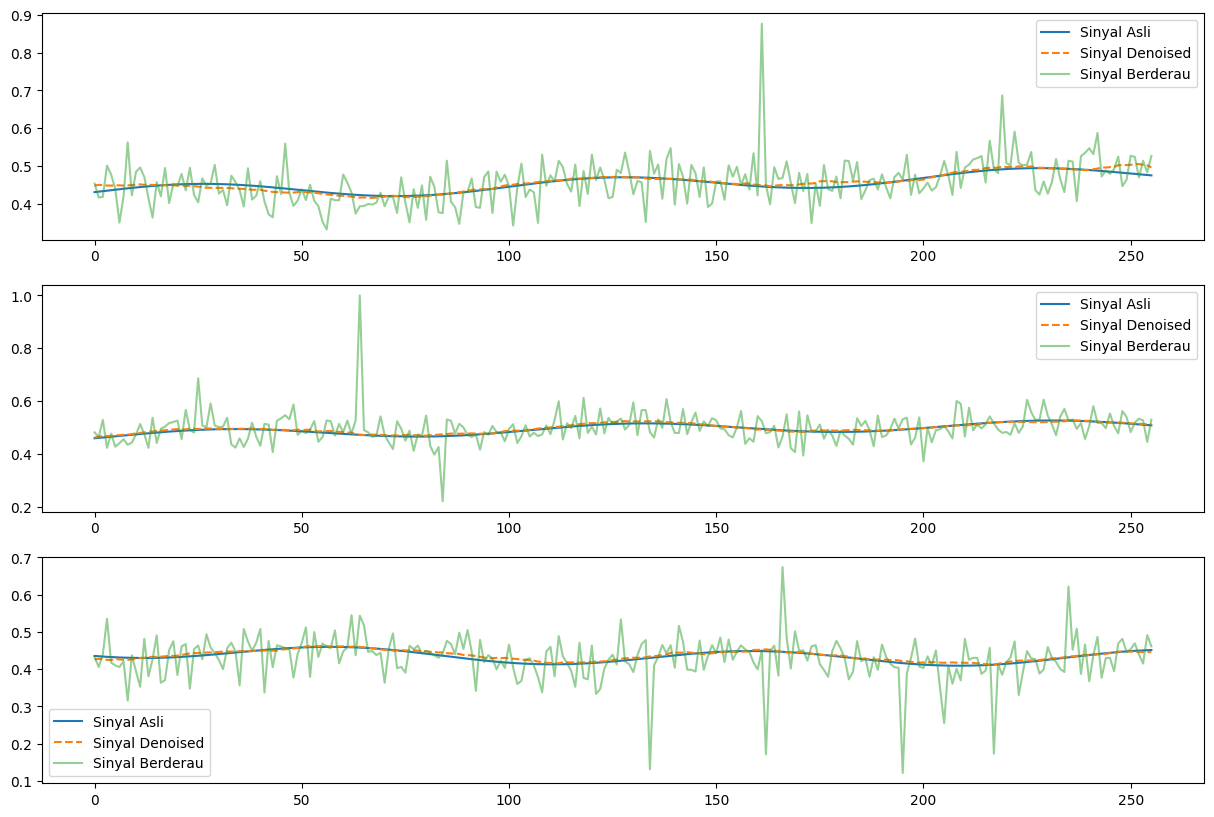

In [5]:
import numpy as np

# Misal: y_true dan y_pred berbentuk array sinyal per window
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

def prd(y_true, y_pred):
    return 100 * np.sqrt(np.sum((y_true - y_pred)**2) / np.sum(y_true**2))

def snr(y_true, y_pred):
    power_signal = np.mean(y_true**2)
    power_noise = np.mean((y_true - y_pred)**2)
    return 10 * np.log10(power_signal / power_noise)

# Lakukan prediksi pada data test
predictions = model.predict(X_test)

# Contoh perhitungan rata-rata seluruh window
rmse_scores = [rmse(a, b) for a, b in zip(Y_test.reshape(-1,256), predictions.reshape(-1,256))]
prd_scores  = [prd(a, b) for a, b in zip(Y_test.reshape(-1,256), predictions.reshape(-1,256))]
snr_scores  = [snr(a, b) for a, b in zip(Y_test.reshape(-1,256), predictions.reshape(-1,256))]

print("RMSE rata-rata:", np.mean(rmse_scores))
print("PRD rata-rata:", np.mean(prd_scores))
print("SNR rata-rata (dB):", np.mean(snr_scores))

# Visualisasi hasil pada beberapa contoh
plt.figure(figsize=(15, 10))
for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.plot(Y_test[i].flatten(), label="Sinyal Asli")
    plt.plot(predictions[i].flatten(), label="Sinyal Denoised", linestyle='--')
    plt.plot(X_test[i].flatten(), alpha=0.5, label="Sinyal Berderau")
    plt.legend()
plt.show()